# Assignment 6: Track 2 Project Report

## Team: dayan-hunt
* Nikhil Kakodkar: 260578689 | nikhil.kakodkar@mail.mcgill.ca
* Karim Koreitem: 260460964 | karim.koreitem@mail.mcgill.ca

In [51]:
import json
import mazes
import sys, os
import argparse
import numpy as np
from numpy.linalg import inv
from math import sqrt
import matplotlib.pyplot as plt
from collections import OrderedDict
from sr_main import run_learning_sr, run_learning_sr_switch

In [61]:
def init_default_config():
    config = {'terminal_step' : 100000,
              'switch_reward_at_step' : 50000,
              'episode_length' : 20,
              'maze_type' : 'SIMPLE_MAZE_R1',
              'maze_params' : {
                  'row' : 2,
                  'col' : 2,
                  'start_row' : 1,
                  'start_col' : 1
              },
              'learning_alg_params' : {
                  'alpha' : 0.01,
                  'gamma' : 0.9,
              },              
             }
    return config

## Question 1: Learning SR using TD(0)

In [62]:
config = init_default_config()
result = run_learning_sr(config)
terminal_step = config['terminal_step']
approx_Phi_pi = result[terminal_step-1]['Phi_pi']

In [63]:
# Calculate exact phi_pi for 2x2 gridworld
state_len = config['maze_params']['row']*config['maze_params']['col']
exact_Phi_pi = np.zeros((state_len, state_len))
gamma = config['learning_alg_params']['gamma']

P_pi = np.array([[0.5, 0.25, 0.25, 0.],
                 [0.25, 0.5, 0., 0.25],
                 [0.25, 0., 0.5, 0.25],
                 [0., 0., 0., 1.]])
exact_Phi_pi = inv(np.identity(4)-gamma*P_pi)

In [64]:
print(exact_Phi_pi)
print(approx_Phi_pi)
print(np.sum(np.abs(exact_Phi_pi-approx_Phi_pi)))

[[ 2.73291925  1.11801242  1.11801242  5.0310559 ]
 [ 1.11801242  2.27555054  0.45736872  6.14906832]
 [ 1.11801242  0.45736872  2.27555054  6.14906832]
 [ 0.          0.          0.         10.        ]]
[[ 2.7845759   1.20067711  1.04764414  4.96710285]
 [ 1.24158009  2.26521341  0.49411603  5.99909046]
 [ 0.98460113  0.40010344  2.35476171  6.26053373]
 [ 0.          0.          0.         10.        ]]
0.9706257888531029


## Question 2: Value Prediction with SR


In [65]:
r1_pi = np.array([-1, -0.75, -0.75, 0.0])
r1_pi = r1_pi.reshape(4,1)
r2_pi = np.array([-0.75, -1, 0., -0.75])
r2_pi = r2_pi.reshape(4,1)

print(r1_pi)
print(r2_pi)



[[-1.  ]
 [-0.75]
 [-0.75]
 [ 0.  ]]
[[-0.75]
 [-1.  ]
 [ 0.  ]
 [-0.75]]


In [66]:
exact_V_pi_R1 = exact_Phi_pi.dot(r1_pi)
approx_V_pi = approx_Phi_pi.dot(r1_pi)
td_V_pi = result[terminal_step-1]['V_pi']
print(exact_V_pi_R1)
print(approx_V_pi)
print(td_V_pi)

[[-4.40993789]
 [-3.16770186]
 [-3.16770186]
 [ 0.        ]]
[[-4.47081684]
 [-3.31107717]
 [-3.05074999]
 [ 0.        ]]
[[-4.33616052]
 [-3.39384675]
 [-2.87536912]
 [ 0.        ]]


## Question 3: Tracking with SR

In [67]:
state_len = config['maze_params']['row']*config['maze_params']['col']
result = run_learning_sr_switch(config)
terminal_step = config['terminal_step']
switch_step = config['switch_reward_at_step']
approx_Phi_pi = result[terminal_step-1]['Phi_pi']

In [68]:
exact_V_R1 = exact_V_pi_R1 
exact_V_R2 = exact_Phi_pi.dot(r2_pi)

V_pi_sr = np.zeros((state_len,1))
V_pi_td = np.zeros((state_len,1))

err_sr = []
err_regular_td = []
for s in range(terminal_step):
    if s <= switch_step:
        V_pi_sr = result[s]['Phi_pi'].dot(r1_pi)
        err_sr.append(np.sum(np.abs(V_pi_sr - exact_V_R1)))
        
        V_pi_td = result[s]['V_pi']
        err_regular_td.append(np.sum(np.abs(V_pi_td - exact_V_R1)))
    else:
        V_pi_sr = result[s]['Phi_pi'].dot(r2_pi)
        err_sr.append(np.sum(np.abs(V_pi_sr - exact_V_R2)))
    
        V_pi_td = result[s]['V_pi']
        err_regular_td.append(np.sum(np.abs(V_pi_td - exact_V_R2)))

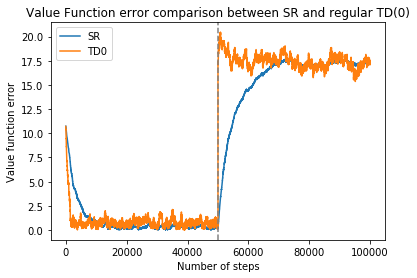

In [69]:
# Plotting value function error for the two algorithms:
plt.ylabel('Value function error')
plt.xlabel('Number of steps')
plt.title('Value Function error comparison between SR and regular TD(0)')
plt.plot(err_sr, label='SR')
plt.plot(err_regular_td, label='TD0')
plt.axvline(x=switch_step, color='grey', linestyle='--')
plt.legend()